In [2]:
import spatialdata
import scanpy as sc

sdata = spatialdata.read_zarr("/Volumes/ProstateCancerEvo_SpatialAnalysis/dbs/Region_1_Xenium_Phen_HE_Integrated.V9.zarr")
adata = sdata.tables["GeneTranscripts_XStock_PhenCyc_Props_Ann"]
sdata

adata.obs['cell_type_manuel'] = (
    adata.obs['cell_type_manuel']
        .str.replace(" ", "_", regex=False)
        .str.replace("/", "OR",   regex=False)
        .str.replace(",", "AND",   regex=False)
        .str.replace("+", "",   regex=False)
        .str.replace(")", "_",   regex=False)
        .str.replace("(", "_",   regex=False)

)


version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creati

In [7]:
import scanpy as sc
import gseapy as gp

def go_fgsea(adata, ref, comp, gene_set="KEGG_2016", show_plot = False):
    Reference, Delta = adata[adata.obs["cell_type_manuel"] == ref], \
                       adata[adata.obs["cell_type_manuel"] == comp]
    
    adata_concat = sc.concat(
        [Reference, Delta],
        axis=0,
        join="inner",                # keep only shared variables
        label="subset",              # name of the new obs‐column
        keys=[ref, comp],
        merge="same"                 # assume var‐ and obsm‐entries are identical
    )

    if show_plot:
         sc.pl.umap(
         adata_concat,
         color="subset",
         palette=["red","blue"],
         size=20,
         title=f"UMAP Comparisons of {ref} as reference vs {comp} as comparison",
         alpha = 0.4)

    # 1) Run differential expression: PartialTumor vs TumorEnriched
    sc.tl.rank_genes_groups(
    adata_concat,
    groupby='subset',
    groups=[comp],
    reference=ref,
    method='t-test'          # or 't-test', 'logreg', etc.
    )

    # 2) Extract a pre-ranked list of genes (log₂-fold-changes)
    de_df = sc.get.rank_genes_groups_df(
    adata_concat,
    group=comp,
    key='rank_genes_groups'
    )
    rnk = de_df.set_index('names')['logfoldchanges']

    pre_res = gp.prerank(
    rnk=rnk,
    gene_sets=gene_set,     # or path to your GMT file
    processes=4,
    permutation_num=1000,
    outdir=None)

    return pre_res.res2d[pre_res.res2d["FDR q-val"] < 0.2] 

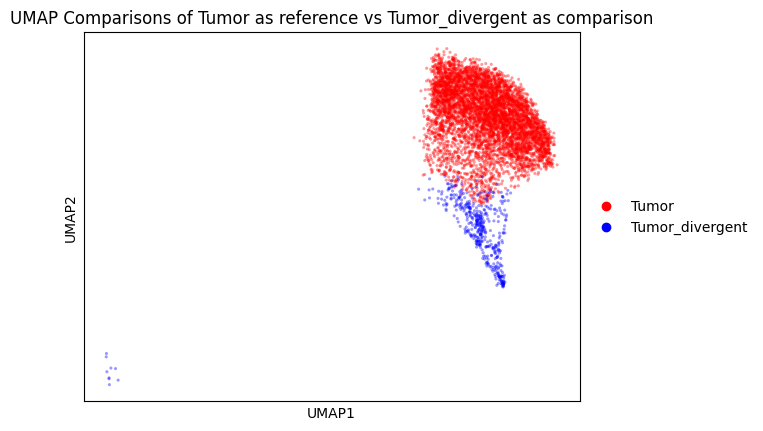

/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_12388/2539484192.py:43: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(
2025-05-22 13:38:05,639 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-05-22 13:38:05,645 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,E2F Targets,0.816918,2.525192,0.0,0.0,0.0,72/102,11.69%,AURKB;ASF1B;BIRC5;MELK;SUV39H1;CDKN3;CDCA3;TOP...
1,prerank,G2-M Checkpoint,0.793691,2.488077,0.0,0.0,0.0,56/107,9.42%,AURKB;NUSAP1;BIRC5;SUV39H1;CDKN3;CCNA2;BUB1;TO...
2,prerank,Mitotic Spindle,0.719505,2.14541,0.0,0.0,0.0,22/71,7.09%,NUSAP1;BIRC5;RASA1;BUB1;TOP2A;PLK1;CENPF;TPX2;...
3,prerank,Myc Targets V1,0.592894,1.784463,0.0,0.001798,0.009,43/78,26.60%,CCNA2;TYMS;CDC20;MAD2L1;MCM4;KPNA2;RRM1;MCM5;M...
4,prerank,Spermatogenesis,0.617158,1.727484,0.0,0.004475,0.027,17/46,9.58%,CDKN3;BUB1;AURKA;KIF2C;CCNB2;TTK;NEK2;EZH2;ACR...
5,prerank,Myc Targets V2,0.679912,1.706414,0.002635,0.005993,0.043,7/24,7.91%,PLK1;PLK4;MCM4;MCM5;UNG;TMEM97;CDK4
6,prerank,mTORC1 Signaling,0.546109,1.660378,0.00221,0.009818,0.08,28/83,18.01%,BUB1;PLK1;RRM2;AURKA;MCM4;FADS1;MCM2;SLC1A5;CD...
7,prerank,DNA Repair,0.584702,1.660008,0.001176,0.00859,0.08,18/44,16.76%,TYMS;POLD1;POLH;FEN1;RFC3;RFC5;RFC4;EIF1B;PCNA...
9,prerank,Estrogen Response Late,0.508257,1.555299,0.007769,0.032853,0.304,26/85,19.14%,KIF20A;TOP2A;CDC20;NMU;XRCC3;PLK4;STIL;CDC6;CA...
10,prerank,Glycolysis,0.517095,1.545708,0.004489,0.033643,0.34,15/68,11.30%,KIF20A;HMMR;AURKA;SDC1;STMN1;ENO2;VEGFA;GUSB;P...


In [8]:
go_fgsea(adata, "Tumor", "Tumor_divergent", gene_set="MSigDB_Hallmark_2020" , show_plot=True)

In [ ]:
#All Names of databases 

names = gseapy.get_library_name()
names   # show the first 20 entries

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell